# Install Libraries

In [1]:
!pip install scikit-learn-extra

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 18.0 MB/s eta 0:00:00


# Import Libraries

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from IPython.core.display import HTML, display
import lxml
from lxml import html
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, silhouette_score
from sklearn.base import BaseEstimator, TransformerMixin
import sklearn_extra
from sklearn_extra.cluster import KMedoids
from pprint import pprint
from xgboost import XGBRegressor
import time
from functools import partial
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# Load Dataset

In [4]:
dataset_path = "Combined_df.csv"
df = pd.read_csv(dataset_path, index_col = 'Unnamed: 0')
df = df[np.isfinite(df['adjusted_price'])]

In [5]:
df, df_test = train_test_split(df, test_size = 0.4, random_state = 42, shuffle = True)
df_val, df_test = train_test_split(df_test, test_size = 0.5, random_state = 42, shuffle = True)

In [6]:
bool_dict = {}
stratify_columns = ['town', 'flat_type', 'storey_range', 'flat_model']
for col in stratify_columns:
  diff_val_test = set(df_test[col].unique()).difference(set(df_val[col].unique()))
  diff_val_train = set(df[col].unique()).difference(set(df_val[col].unique()))
  is_col_same = len(diff_val_test) == len(diff_val_train) == 0
  bool_dict[col] = is_col_same
pprint(bool_dict)

{'flat_model': True, 'flat_type': True, 'storey_range': True, 'town': True}


In [7]:
print(f"Train_set_size: {df.shape[0]}\n\
Validation_set_size: {df_val.shape[0]}\n\
Test_set_size: {df_test.shape[0]}")

Train_set_size: 109786
Validation_set_size: 36595
Test_set_size: 36596


In [8]:
columns_to_drop = ['month', 'block', 'street_name', 'lease_commence_date', 'resale_price']

# Feature processing

## Towns

In [ ]:
df_town = df[['town', 'adjusted_price']]

In [ ]:
len(df_town['town'].unique())

26

### Kmeans

In [ ]:
df_town_2 = df_town.sample(10000)
silhouette_avg = silhouette_score(df_town_2[['adjusted_price']], df_town_2['town'], metric='euclidean')
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: -0.2911463337420345


In [ ]:
cluster_size = [i for i in range(2, len(df_town['town'].unique()) + 1)]
c_score = []
for c_size in cluster_size:
  category_mean_prices = df_town.copy().groupby('town')['adjusted_price'].mean().reset_index()
  category_mean_prices.columns = ['town', 'mean_price']
  # Prepare the data for clustering (mean price for each category)
  X = category_mean_prices[['mean_price']].values

  # Perform KMeans clustering
  kmeans = KMeans(n_clusters=c_size, random_state=42)
  category_mean_prices['cluster'] = kmeans.fit_predict(X)

  # Map the cluster labels to the original dataframe
  df_town_2 = df_town.copy()
  df_town_2 = df_town_2.merge(category_mean_prices[['town', 'cluster']], on='town', how='left')

  # Calculate silhouette score on continuous target values
  for i in range(5):
    df_town_3 = df_town_2.sample(10000)
    silhouette_avg = silhouette_score(df_town_3[['adjusted_price']], df_town_3['cluster'], metric='euclidean')
    c_score.append(silhouette_avg)
  print(f"Silhouette Score (n = {c_size}): {sum(c_score) / 5}")
  c_score.clear()

Silhouette Score (n = 2): 0.33589409079849164
Silhouette Score (n = 3): 0.017420564912900328
Silhouette Score (n = 4): -0.005124984986312606
Silhouette Score (n = 5): -0.0788749745039822
Silhouette Score (n = 6): -0.07904579085361749
Silhouette Score (n = 7): -0.15317906257057684
Silhouette Score (n = 8): -0.18727790682219303
Silhouette Score (n = 9): -0.1931069663502546
Silhouette Score (n = 10): -0.20552524957868093
Silhouette Score (n = 11): -0.25980144064372873
Silhouette Score (n = 12): -0.26143743682345155
Silhouette Score (n = 13): -0.26767281780460295
Silhouette Score (n = 14): -0.26794714757928445
Silhouette Score (n = 15): -0.2680065636853312
Silhouette Score (n = 16): -0.2680173356125347
Silhouette Score (n = 17): -0.2781706721883218
Silhouette Score (n = 18): -0.28073100122803335
Silhouette Score (n = 19): -0.2754989504106028
Silhouette Score (n = 20): -0.3008176097997112
Silhouette Score (n = 21): -0.300289965191891
Silhouette Score (n = 22): -0.29976051618984445
Silhouett

<b> Based on scoring, should clustter to 2

               town     mean_price  cluster
0        ANG MO KIO  409567.071454        1
1             BEDOK  409562.991613        1
2            BISHAN  623225.395852        0
3       BUKIT BATOK  407620.916251        1
4       BUKIT MERAH  550884.121975        0
5     BUKIT PANJANG  435729.090849        1
6       BUKIT TIMAH  685029.557089        0
7      CENTRAL AREA  595928.661027        0
8     CHOA CHU KANG  410263.793291        1
9          CLEMENTI  478193.307874        1
10          GEYLANG  428503.461328        1
11          HOUGANG  440364.003527        1
12      JURONG EAST  411501.673367        1
13      JURONG WEST  396217.481070        1
14  KALLANG/WHAMPOA  493629.121143        1
15    MARINE PARADE  485380.848808        1
16        PASIR RIS  501943.900490        1
17          PUNGGOL  457628.680515        1
18       QUEENSTOWN  550122.045202        0
19        SEMBAWANG  401797.702681        1
20         SENGKANG  444484.293303        1
21        SERANGOON  486945.4663

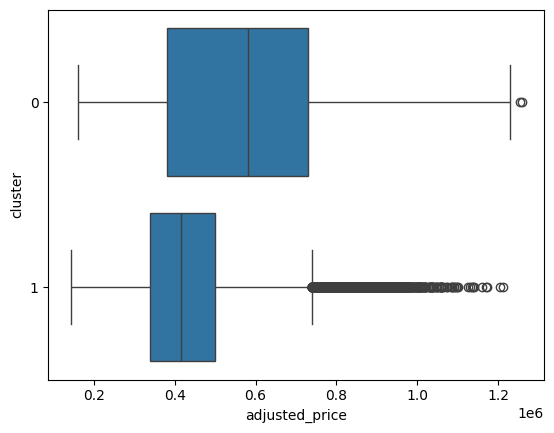

In [ ]:
  category_mean_prices = df_town.copy().groupby('town')['adjusted_price'].mean().reset_index()
  category_mean_prices.columns = ['town', 'mean_price']
  # Prepare the data for clustering (mean price for each category)
  X = category_mean_prices[['mean_price']].values

  # Perform KMeans clustering (e.g., 2 clusters in this example)
  kmeans = KMeans(n_clusters=2, random_state=42)
  category_mean_prices['cluster'] = kmeans.fit_predict(X)

  # View the resulting clusters
  print(category_mean_prices)
  # Map the cluster labels to the original dataframe
  df_town_2 = df_town.copy()
  df_town_2 = df_town_2.merge(category_mean_prices[['town', 'cluster']], on='town', how='left')

  print(df_town_2)
  sns.boxplot(df_town_2, x = 'adjusted_price', y = 'cluster', orient = 'h')
  plt.show()

  from sklearn.metrics import silhouette_score

  # Calculate silhouette score on continuous target values
  #df_town_3 = df_town_2.sample(10000)
  #silhouette_avg = silhouette_score(df_town_3[['adjusted_price']], df_town_3['cluster'], metric='euclidean')
  #print(f"Silhouette Score: {silhouette_avg}")
  #c_score.append(silhouette_avg)

<b> Not implemented as found to yield worse performance over median ordinal encoding

### Kmedoids

#### Test of KMedoids

In [ ]:
df_town = df[['town', 'adjusted_price']]

# Calculate the mean price for each town
category_mean_prices_town = df_town.groupby('town')['adjusted_price'].mean().reset_index()
category_mean_prices_town.columns = ['town', 'mean_price']

# Prepare data for clustering
X = category_mean_prices_town[['mean_price']].values

def evaluate_k_medians_medoids(X, cluster_method, k_range):
    results = []
    for k in k_range:
        if cluster_method == 'kmedoids':
            model = KMedoids(n_clusters=k, metric='euclidean', random_state=42)
        else:
            raise ValueError("Invalid method. Choose 'kmedians' or 'kmedoids'.")

        model.fit(X)
        inertia_or_cost = model.inertia_  # Inertia (k-medians) or cost (k-medoids)
        silhouette_avg = silhouette_score(X, model.labels_) if k > 1 else np.nan

        results.append({
            'Clusters': k,
            'Inertia/Cost': inertia_or_cost,
            'Silhouette Score': silhouette_avg
        })
    return pd.DataFrame(results)

# Define range of clusters to test
k_range = range(2, len(df_town['town'].unique()))

# Evaluate k-medoids
kmedoids_results = evaluate_k_medians_medoids(X, 'kmedoids', k_range)
print("k-medoids evaluation results:")
print(kmedoids_results)

k-medoids evaluation results:
    Clusters   Inertia/Cost  Silhouette Score
0          2  837479.618334          0.513061
1          3  720117.789521          0.401866
2          4  375181.749757          0.590352
3          5  361791.634625          0.487744
4          6  331584.915865          0.466749
5          7  327464.626089          0.402290
6          8  315724.804703          0.393471
7          9  311010.293703          0.313717
8         10  304579.066959          0.299411
9         11  297353.437439          0.277261
10        12  264092.287745          0.270477
11        13  250724.978234          0.303305
12        14  248790.376321          0.182721
13        15  248089.574643          0.111951
14        16  248085.494801          0.081759
15        17  246520.877221          0.015409
16        18  244578.801859          0.043061
17        19  237556.348126          0.082845
18        20  235487.353381          0.026291
19        21  215563.565111          0.052212
20  

                 town  adjusted_price  cluster
0         BUKIT MERAH   555035.812017        0
1       BUKIT PANJANG   538540.708745        1
2       CHOA CHU KANG   475471.629042        1
3               BEDOK   275624.169987        1
4             PUNGGOL   457645.184649        0
...               ...             ...      ...
109781    BUKIT BATOK   273682.123246        1
109782      WOODLANDS   365324.722444        1
109783        PUNGGOL   410223.081499        0
109784      PASIR RIS   502896.313364        0
109785  BUKIT PANJANG   349685.306365        1

[109786 rows x 3 columns]


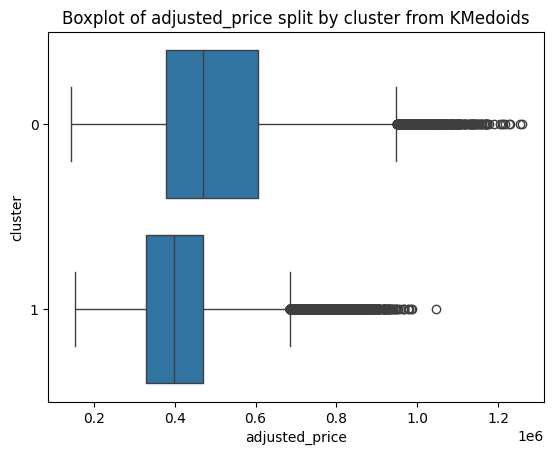

In [ ]:
# plot box plot
category_mean_prices = df_town.copy().groupby('town')['adjusted_price'].mean().reset_index()
category_mean_prices.columns = ['town', 'mean_price']
# Prepare the data for clustering (mean price for each category)
X = category_mean_prices[['mean_price']].values

# Perform KMeans clustering (e.g., 2 clusters in this example)
kmedoids = KMedoids(n_clusters=2, random_state=42)
category_mean_prices['cluster'] = kmedoids.fit_predict(X)

df_town_2 = df_town.copy()
df_town_2 = df_town_2.merge(category_mean_prices[['town', 'cluster']], on='town', how='left')

print(df_town_2)
sns.boxplot(df_town_2, x = 'adjusted_price', y = 'cluster', orient = 'h')
plt.title("Boxplot of adjusted_price split by cluster from KMedoids")
plt.xlabel("adjusted_price")
plt.show()

<b> Not implemented

## Flat Model

In [ ]:
df_flat_model = df[['flat_model', 'adjusted_price']]

### Kmeans

In [ ]:
from sklearn.cluster import KMeans
cluster_size = range(2, len(df_flat_model['flat_model'].unique()))
c_score = []
for c_size in cluster_size:
  category_mean_prices = df_flat_model.copy().groupby('flat_model')['adjusted_price'].mean().reset_index()
  category_mean_prices.columns = ['flat_model', 'mean_price']
  # Prepare the data for clustering (mean price for each category)
  X = category_mean_prices[['mean_price']].values

  # Perform KMeans clustering (e.g., 2 clusters in this example)
  kmeans = KMeans(n_clusters=c_size, random_state=42)
  category_mean_prices['cluster'] = kmeans.fit_predict(X)

  # Map the cluster labels to the original dataframe
  df_flat_model_2 = df_flat_model.copy()
  df_flat_model_2 = df_flat_model_2.merge(category_mean_prices[['flat_model', 'cluster']], on='flat_model', how='left')

  # Calculate silhouette score on continuous target values
  for i in range(5):
    df_flat_model_3 = df_flat_model_2.sample(10000)
    silhouette_avg = silhouette_score(df_flat_model_3[['adjusted_price']], df_flat_model_3['cluster'], metric='euclidean')
    c_score.append(silhouette_avg)
  print(f"Silhouette Score (n = {c_size}): {sum(c_score) / 5}")
  c_score.clear()

Silhouette Score (n = 2): 0.3955820585658975
Silhouette Score (n = 3): -0.009541135979515964
Silhouette Score (n = 4): -0.03691865442784342
Silhouette Score (n = 5): -0.07549683235505589
Silhouette Score (n = 6): -0.1630279297998257
Silhouette Score (n = 7): -0.20092054153443611
Silhouette Score (n = 8): -0.28217069476424134
Silhouette Score (n = 9): -0.3389844595862078
Silhouette Score (n = 10): -0.3099729482152515
Silhouette Score (n = 11): -0.3008833507932866
Silhouette Score (n = 12): -0.35600471976894454
Silhouette Score (n = 13): -0.3739540732108505
Silhouette Score (n = 14): -0.35364086121621296
Silhouette Score (n = 15): -0.3528882316877883
Silhouette Score (n = 16): -0.4455067717417112
Silhouette Score (n = 17): -0.414954639978166
Silhouette Score (n = 18): -0.4993888277042104
Silhouette Score (n = 19): -0.5318136365299206
Silhouette Score (n = 20): -0.4983658891146808


                flat_model    mean_price  cluster
0                   2-room  2.486865e+05        1
1                     3Gen  5.509165e+05        1
2            Adjoined flat  6.565004e+05        0
3                Apartment  6.166452e+05        0
4                     DBSS  7.061825e+05        0
5                 Improved  4.552508e+05        1
6      Improved-Maisonette  6.496202e+05        0
7               Maisonette  6.751940e+05        0
8                  Model A  4.293496e+05        1
9       Model A-Maisonette  6.798981e+05        0
10                Model A2  3.558829e+05        1
11        Multi Generation  7.672211e+05        0
12          New Generation  3.305132e+05        1
13       Premium Apartment  4.794297e+05        1
14  Premium Apartment Loft  8.697916e+05        0
15      Premium Maisonette  7.551996e+05        0
16              Simplified  3.434226e+05        1
17                Standard  3.853846e+05        1
18                 Terrace  7.869950e+05        0


Text(0.5, 0, 'adjusted_price')

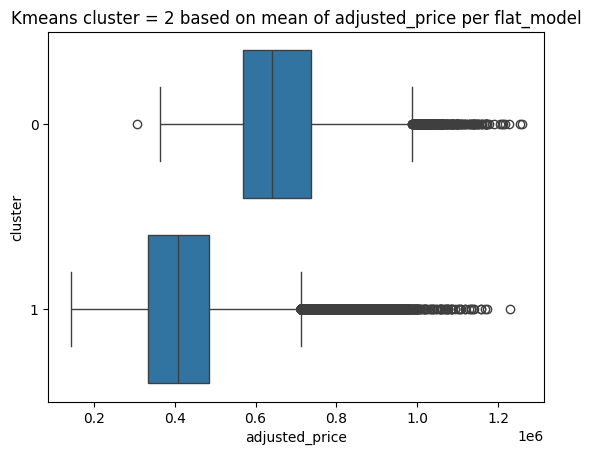

In [ ]:
category_mean_prices = df_flat_model.copy().groupby('flat_model')['adjusted_price'].mean().reset_index()
category_mean_prices.columns = ['flat_model', 'mean_price']
# Prepare the data for clustering (mean price for each category)
X = category_mean_prices[['mean_price']].values

# Perform KMeans clustering (e.g., 2 clusters in this example)
kmeans = KMeans(n_clusters=2, random_state=42)
category_mean_prices['cluster'] = kmeans.fit_predict(X)

# View the resulting clusters
print(category_mean_prices)
# Map the cluster labels to the original dataframe
df_flat_model_2 = df_flat_model.copy()
df_flat_model_2 = df_flat_model_2.merge(category_mean_prices[['flat_model', 'cluster']], on='flat_model', how='left')

print(df_flat_model_2)
sns.boxplot(df_flat_model_2, x = 'adjusted_price', y = 'cluster', orient = 'h')
plt.title("Kmeans cluster = 2 based on mean of adjusted_price per flat_model")
plt.xlabel("adjusted_price")

# Column Transformer

### Storey Range Transform

In [9]:
def storey_range_transform(row):
  row_applied = row['storey_range'].str.split().apply(lambda x: x[-1]).astype(np.int8)
  return pd.DataFrame(row_applied)

### Town Transformer

#### Kmediods

In [10]:
df_town = df[['town', 'adjusted_price']]
# consider using median
category_mean_prices_town = df_town.copy().groupby('town')['adjusted_price'].mean().reset_index()
category_mean_prices_town.columns = ['town', 'mean_price']
# Prepare the data for clustering (mean price for each category)
X = category_mean_prices_town[['mean_price']].values

# Perform KMeans clustering
kmeans_town = KMedoids(n_clusters = 2, random_state = 42)
category_mean_prices_town['cluster'] = kmeans_town.fit_predict(X)

_dict = {t: cluster for t, cluster in zip(category_mean_prices_town['town'], category_mean_prices_town['cluster'])}


# need change name
def kmedoids_town(row):

  # Map the cluster labels to the original dataframe
  temp_df = pd.DataFrame(row).merge(category_mean_prices_town[['town', 'cluster']], on='town', how='left')
  return pd.DataFrame(temp_df['cluster'])

#### Ordinnal encoding by median

In [11]:
def ordinal_encode_by_target_median(df, categorical_column, target_column):
    """
    Ordinally encodes a categorical column based on the median of a target column.

    Parameters:
    - df: pandas DataFrame containing the data.
    - categorical_column: name of the categorical column to encode.
    - target_column: name of the continuous target column used for median calculation.

    Returns:
    - A DataFrame with the encoded column.
    """
    # Calculate the median target value for each category
    median_per_category = (
        df.groupby(categorical_column)[target_column]
        .median()
        .sort_values()
    )

    # Create a mapping from category to ordinal integer based on sorted medians
    ordinal_mapping = {category: idx for idx, category in enumerate(median_per_category.index)}

    # Map the categorical column to its ordinal values

    # return df
    return ordinal_mapping


# Apply the encoding
df_encoded = ordinal_encode_by_target_median(df_town.copy(), 'town', 'adjusted_price')

#### Town Transformer

In [12]:
def town_transformer(transform_type):
  if transform_type == 'kmeans':
    return FunctionTransformer(func = kmedoids_town)
  elif transform_type == 'ohe':
    return OneHotEncoder(dtype = np.int8)
  else:
    return FunctionTransformer(func = lambda row: pd.DataFrame(row['town'].apply(lambda x: df_encoded[x])))

### Remaining Lease Transformer

In [13]:
def remaining_lease_transform(row):
  years_left = row['remaining_lease'].str.split().apply(lambda row: row[0]).astype(np.int16)
  return pd.DataFrame(years_left)

### Flat Model Transformer

#### Kmeans

In [14]:
#flat_model, cluster by 2 or 6
df_flat_model = df[['flat_model', 'adjusted_price']]

category_mean_prices_flat_model = df_flat_model.copy().groupby('flat_model')['adjusted_price'].mean().reset_index()
category_mean_prices_flat_model.columns = ['flat_model', 'mean_price']

# Prepare the data for clustering (mean price for each category)
X = category_mean_prices_flat_model[['mean_price']].values

# Perform KMeans clustering (e.g., 2 clusters in this example)
kmeans_flat_model = KMeans(n_clusters=2, random_state=42) #using kmediods with cluster size 7 yields better results over ordinal encoding
category_mean_prices_flat_model['cluster'] = kmeans_flat_model.fit_predict(X)


def kmeans_flat_model(row):

  # Map the cluster labels to the original dataframe
  temp_df = pd.DataFrame(row).merge(category_mean_prices_flat_model[['flat_model', 'cluster']], on='flat_model', how='left')
  return pd.DataFrame(temp_df['cluster'])

#### Ordinal Encode by Median

In [15]:
def ordinal_encode_by_target_median(df, categorical_column, target_column):
    """
    Ordinally encodes a categorical column based on the median of a target column.

    Parameters:
    - df: pandas DataFrame containing the data.
    - categorical_column: name of the categorical column to encode.
    - target_column: name of the continuous target column used for median calculation.

    Returns:
    - A DataFrame with the encoded column.
    """
    # Calculate the median target value for each category
    median_per_category = (
        df.groupby(categorical_column)[target_column]
        .median()
        .sort_values()
    )

    # Create a mapping from category to ordinal integer based on sorted medians
    ordinal_mapping = {category: idx for idx, category in enumerate(median_per_category.index)}

    # return df
    return ordinal_mapping

# Apply the encoding
df_encoded_flat = ordinal_encode_by_target_median(df_flat_model.copy(), 'flat_model', 'adjusted_price')

#### flat_model_transformer

In [16]:
def flat_model_transformer(transform_type):
  if transform_type == 'kmeans':
    return FunctionTransformer(func = kmeans_flat_model)
  elif transform_type == 'ohe':
    return OneHotEncoder(dtype = np.int8)
  else:
    return FunctionTransformer(func = lambda row: pd.DataFrame(row['flat_model'].apply(lambda x: df_encoded_flat[x])))

### Flat Type Transformer

In [17]:
class OrdinalEncoderByTargetMedian(BaseEstimator, TransformerMixin):
    def __init__(self, categorical_column, target_column):
        self.categorical_column = categorical_column
        self.target_column = target_column
        self.ordinal_mapping_ = None

    def fit(self, X, y=None):
        # Compute the median of the target for each category in the categorical column
        median_per_category = (
            X.groupby(self.categorical_column)[self.target_column]
            .median()
            .sort_values()
        )

        # Create a mapping dictionary where each category gets an ordinal value
        self.ordinal_mapping_ = {category: idx for idx, category in enumerate(median_per_category.index)}

        return self

    def transform(self, X):
        # Map categories to ordinal values
        X_transformed = X[self.categorical_column].map(self.ordinal_mapping_)
        return X_transformed.to_frame()

# Sample usage
ordinal_encoder = OrdinalEncoderByTargetMedian(categorical_column='flat_type', target_column='adjusted_price')
ordinal_encoder.fit(df)
def flat_type_transform(row):
  encoding = ordinal_encoder.transform(row)
  return encoding


### Make Column Transformer

In [18]:

# FunctionTransformer(func = kmeans_town)
#FunctionTransformer(func = kmeans_flat_model)
def make_column_transformer(df, town_transform = '', flat_model_transform = ''):
  ct = ColumnTransformer(
      [("town", town_transformer(town_transform), [np.where(df.columns == 'town')[0][0]]),
        ("floor_area", FunctionTransformer(func = np.log), [np.where(df.columns == 'floor_area_sqm')[0][0]]), # log transform floor area
        ("storey_range", FunctionTransformer(func = storey_range_transform), [np.where(df.columns == 'storey_range')[0][0]]), # use max floor as category, if need not numerical, can use as it is
        ("flat_type", FunctionTransformer(func = flat_type_transform), [np.where(df.columns == 'flat_type')[0][0]]), # flat type as it is, if need numerical cat, use ordinal
        ("remaining_lease", FunctionTransformer(func = remaining_lease_transform), [np.where(df.columns == 'remaining_lease')[0][0]]),
        ("flat_model", flat_model_transformer(flat_model_transform), [np.where(df.columns == 'flat_model')[0][0]])
       ],
      remainder = 'passthrough')
  return ct

### Test Column Transformer

In [19]:
df_test_test = df.copy()
ct = make_column_transformer(df_test_test)
ct.fit_transform(df_test_test)

array([[22, 4.804021044733257, 3, ..., 0.5429982213975426,
        0.3264856574317982, 3.340542004610571],
       [12, 4.727387818712341, 12, ..., 0.2284436830332666,
        0.3520681003369673, 1.6665420798695627],
       [9, 4.727387818712341, 9, ..., 0.1981846450178264,
        0.7642430381411763, 1.716581524759181],
       ...,
       [16, 4.700480365792417, 3, ..., 0.1751459620231693,
        0.4969515471915094, 3.602704537640319],
       [20, 4.795790545596741, 6, ..., 0.7445537217300727,
        0.3987844639291563, 1.9907421355060977],
       [12, 4.51085950651685, 3, ..., 0.5528013482391219,
        0.7841648767546312, 2.1220112422252373]], dtype=object)

# Model Training

## Decision Tree Regressor

### OHE

In [ ]:
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']
# Initialize and train the Decision Tree Regressor
ct = make_column_transformer(X_train, town_transform = 'ohe', flat_model_transform = 'ohe')
X_train = ct.fit_transform(X_train)
X_val = ct.fit_transform(X_val)
X_test = ct.transform(X_test)
regressor = DecisionTreeRegressor(random_state=42)

"""
pipeline = Pipeline([
    ('preprocessor', ct),
    ('regressor', DecisionTreeRegressor(random_state=42))
])
"""
regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)
# y_pred = pipeline.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1175931069.1788855
Root Mean Squared Error (RMSE): 34291.851352455225


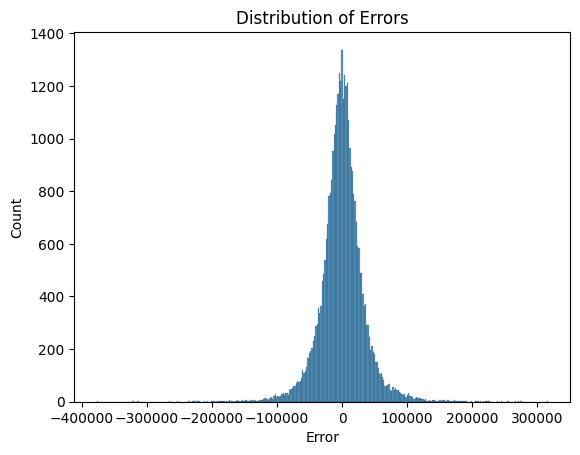

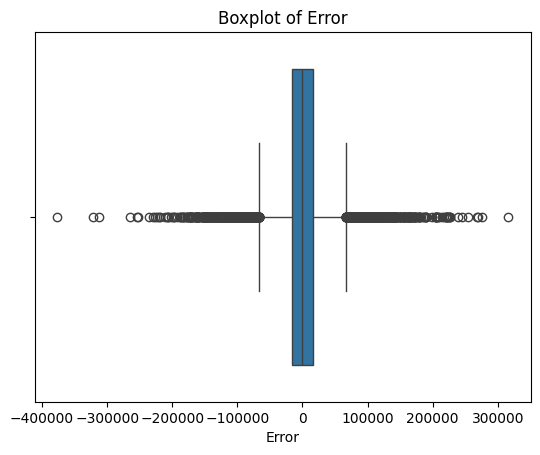

R squared on train: 0.9985322245926198
R squared on validation: 0.94608035317946
R squared on test: 0.94517060364145


In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
# sns.barplot(x = regressor.feature_names_in_, y = regressor.feature_importances_)
# plt.xticks(rotation = 90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,18741.054949
2 ROOM,17775.851907
3 ROOM,26175.674859
4 ROOM,31468.647997
5 ROOM,40798.563159
EXECUTIVE,48811.485499
MULTI-GENERATION,80603.899155


,adjusted_price
flat_type,
1 ROOM,12867.580625
2 ROOM,11904.485151
3 ROOM,18362.384053
4 ROOM,22418.955522
5 ROOM,28983.078112
EXECUTIVE,33149.514043
MULTI-GENERATION,50625.730573


### Without clustering

In [ ]:
# Split into training and testing sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']
# Initialize and train the Decision Tree Regressor
ct = make_column_transformer(X_train, town_transform = "", flat_model_transform = "")
X_train = ct.fit_transform(X_train)
X_val = ct.fit_transform(X_val)
X_test = ct.transform(X_test)
regressor = DecisionTreeRegressor(random_state=42)

regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)
# y_pred = pipeline.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1199218247.0540986
Root Mean Squared Error (RMSE): 34629.73068122388


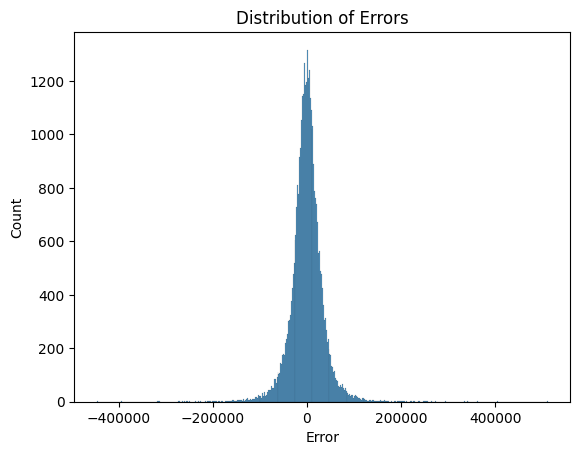

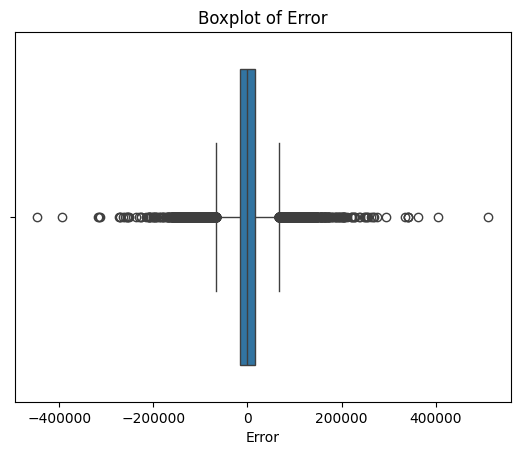

R squared on train: 0.9985322245926198
R squared on validation: 0.9465521053462842
R squared on test: 0.9440848070847832


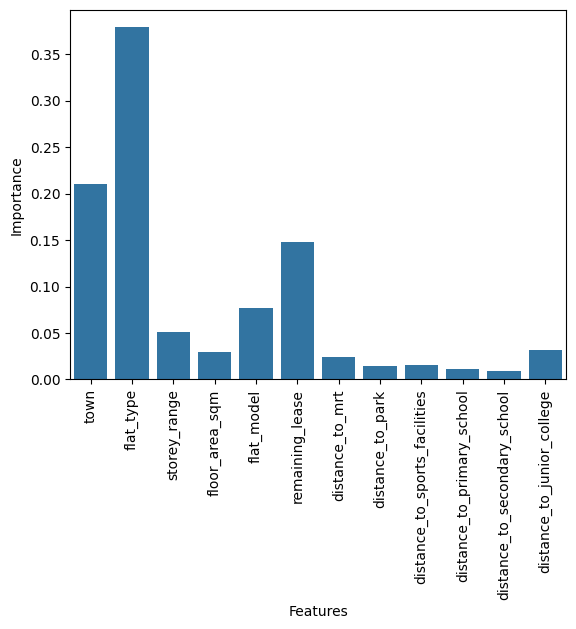

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,18741.054949
2 ROOM,17971.679914
3 ROOM,25517.573166
4 ROOM,31329.706512
5 ROOM,42333.663595
EXECUTIVE,48888.637577
MULTI-GENERATION,115758.300066


,adjusted_price
flat_type,
1 ROOM,12867.580625
2 ROOM,12387.859502
3 ROOM,17497.183638
4 ROOM,22365.680296
5 ROOM,30925.413765
EXECUTIVE,33665.457874
MULTI-GENERATION,83759.813993


### With clustering on flat_model

In [ ]:
# Split into training and testing sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']
# Initialize and train the Decision Tree Regressor
ct = make_column_transformer(X_train, town_transform = "", flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.fit_transform(X_val)
X_test = ct.transform(X_test)
regressor = DecisionTreeRegressor(random_state=42)

regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 1196887825.7449048
Root Mean Squared Error (RMSE): 34596.06662244864


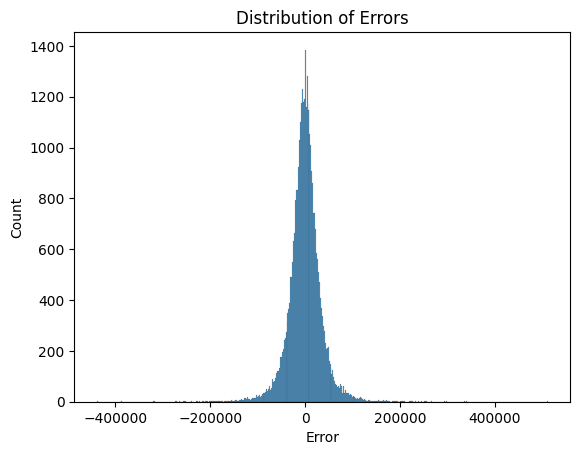

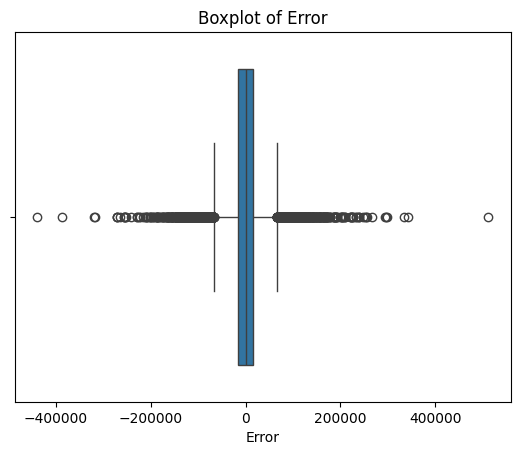

R squared on train: 0.9985221031404953
R squared on train: 0.9472976643824892
R squared on train: 0.9441934661694805


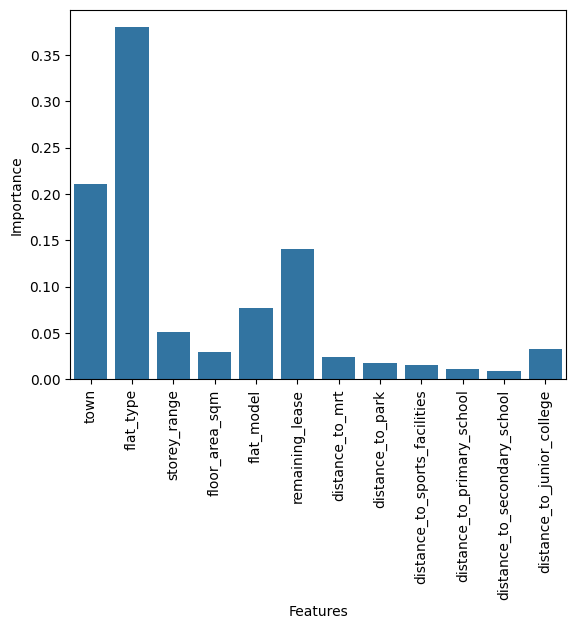

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on train:", regressor.score(X_val, y_val))
print("R squared on train:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,18741.054949
2 ROOM,17895.135451
3 ROOM,26665.138158
4 ROOM,31536.521834
5 ROOM,41800.073795
EXECUTIVE,47995.210664
MULTI-GENERATION,47319.416949


,adjusted_price
flat_type,
1 ROOM,12867.580625
2 ROOM,12301.059931
3 ROOM,18807.235261
4 ROOM,22557.868481
5 ROOM,30229.540625
EXECUTIVE,32407.617575
MULTI-GENERATION,30401.715108


## Random Forest Regressor

### Without Clustering

In [ ]:
# Split into training and testing sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']
# Initialize and train the Decision Tree Regressor
ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = '')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)
regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 666407823.737644
Root Mean Squared Error (RMSE): 25814.876016313618


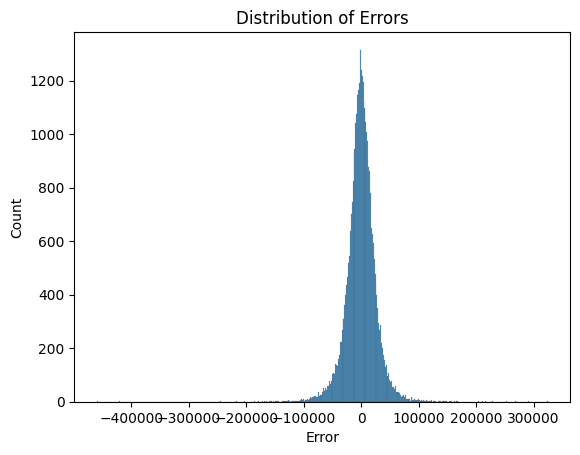

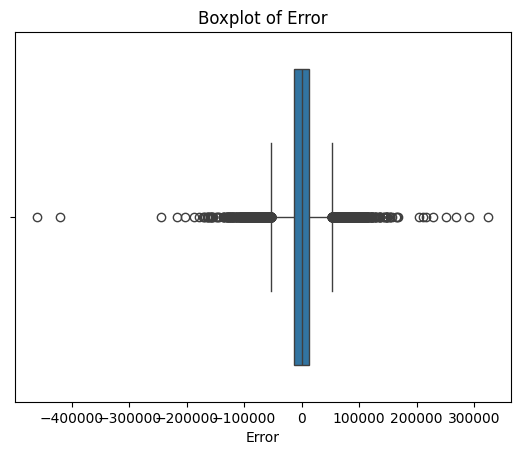

R squared on train: 0.9946725528493774
R squared on validation: 0.9701047600660949
R squared on test: 0.96892782267445


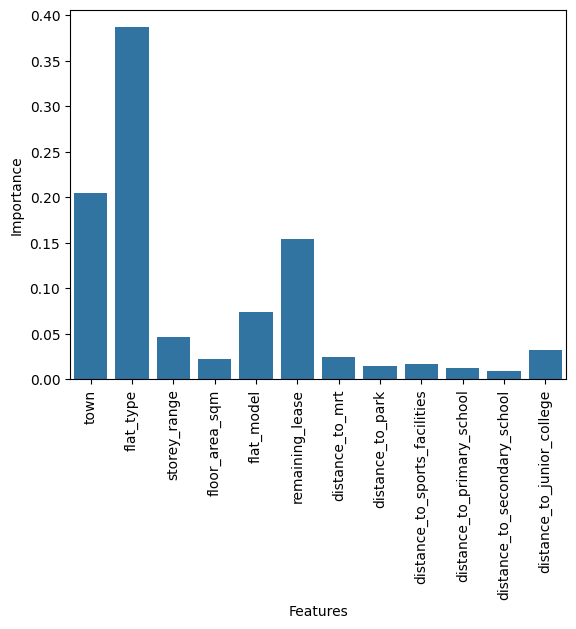

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,17434.780386
2 ROOM,14783.369546
3 ROOM,19977.975251
4 ROOM,23814.250324
5 ROOM,30209.198203
EXECUTIVE,37015.807591
MULTI-GENERATION,66642.647883


,adjusted_price
flat_type,
1 ROOM,11193.227127
2 ROOM,10313.634173
3 ROOM,13715.312975
4 ROOM,16680.044540
5 ROOM,21125.820837
EXECUTIVE,24875.791840
MULTI-GENERATION,32961.317821


### With Clustering

In [ ]:
# Split into training and testing sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']
# Initialize and train the Decision Tree Regressor
ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)
regressor = RandomForestRegressor(random_state=42)

regressor.fit(X_train, y_train)

# Make predictions
y_pred = regressor.predict(X_test)

# Calculate MSE and RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Display the results
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Squared Error (MSE): 673944924.1098274
Root Mean Squared Error (RMSE): 25960.449227812438


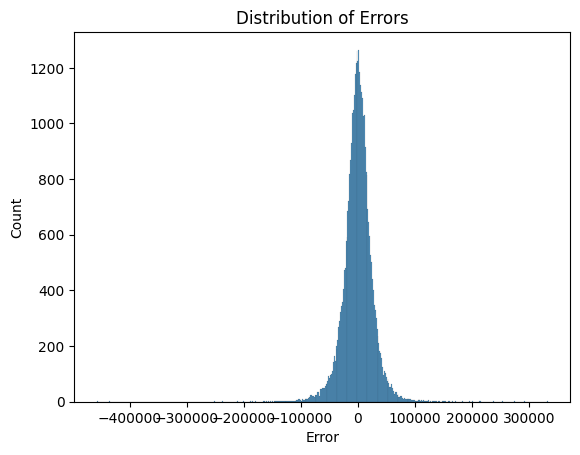

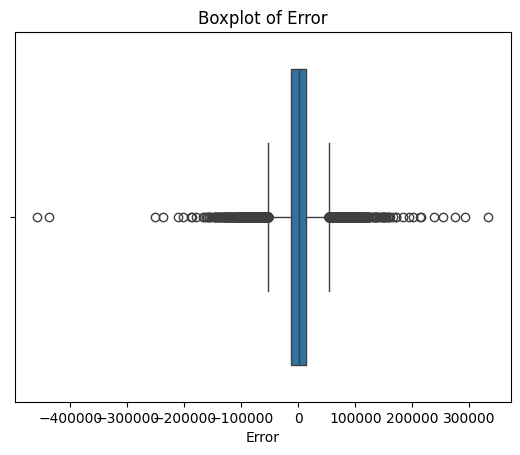

R squared on train: 0.9946438030238732
R squared on validation: 0.9698783007635554
R squared on test: 0.9685763950486885


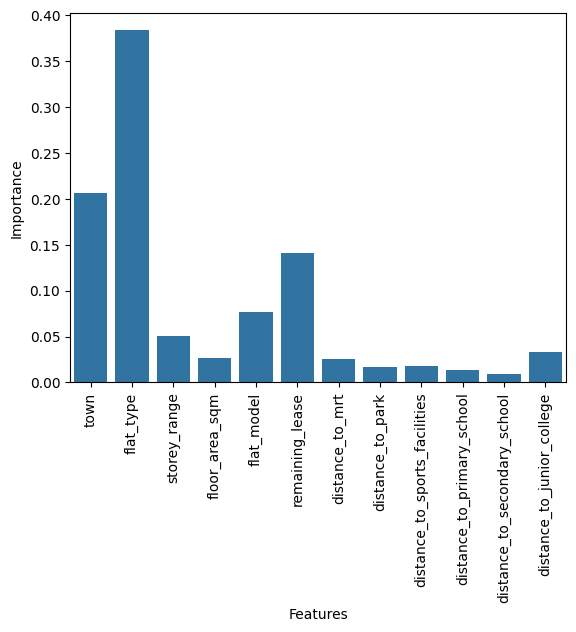

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,17394.434239
2 ROOM,15112.986899
3 ROOM,20128.671656
4 ROOM,23917.515583
5 ROOM,30351.657010
EXECUTIVE,37407.379655
MULTI-GENERATION,58550.237016


,adjusted_price
flat_type,
1 ROOM,11187.351067
2 ROOM,10725.406192
3 ROOM,13885.318770
4 ROOM,16756.105337
5 ROOM,21295.172669
EXECUTIVE,25299.918197
MULTI-GENERATION,26882.473649


## XGBoost

### Without clustering

In [ ]:
# Split the data into training and test sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = '')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

# Initialize the XGBoost regressor
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',  # Objective for regression
    n_estimators=200,              # Number of trees
    learning_rate=0.1,             # Learning rate
    max_depth=15,                   # Maximum tree depth
    random_state=42,                # Random seed
)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Define functions for evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse, rmse = evaluate_model(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 652542824.32
Root Mean Squared Error (RMSE): 25544.92


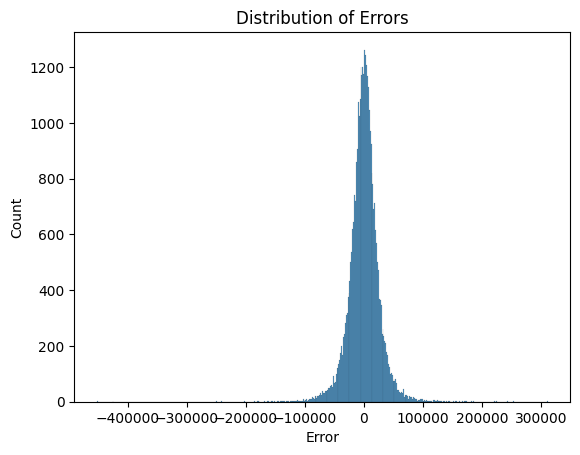

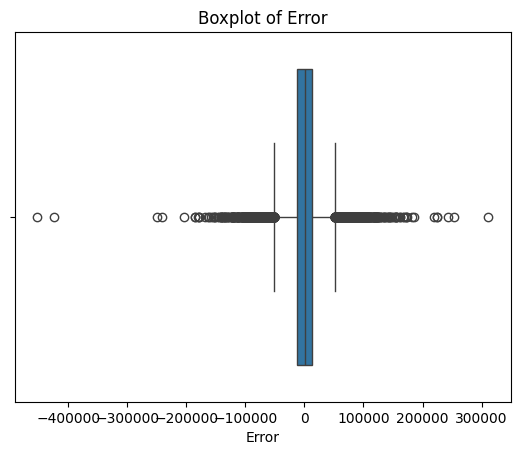

R squared on train: 0.9152640620255986
R squared on validation: 0.888737782688948
R squared on test: 0.8931307231537623


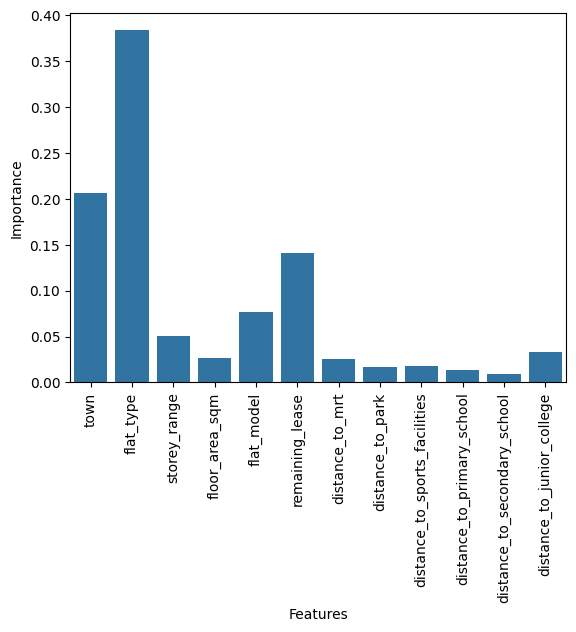

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,18633.129175
2 ROOM,15197.106827
3 ROOM,19895.731795
4 ROOM,23510.170222
5 ROOM,29480.710869
EXECUTIVE,37777.934517
MULTI-GENERATION,54276.416548


,adjusted_price
flat_type,
1 ROOM,11116.750791
2 ROOM,10815.349202
3 ROOM,13854.663117
4 ROOM,16573.884419
5 ROOM,20660.774297
EXECUTIVE,25187.929832
MULTI-GENERATION,30296.661061


### With Clustering

In [ ]:
# Split the data into training and test sets
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

# Initialize the XGBoost regressor
xgb_regressor = XGBRegressor(
    objective='reg:squarederror',  # Objective for regression
    n_estimators=200,              # Number of trees
    learning_rate=0.1,             # Learning rate
    max_depth=15,                   # Maximum tree depth
    random_state=42,                # Random seed
)

# Train the model
xgb_regressor.fit(X_train, y_train)

# Define functions for evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

# Make predictions on the test set
y_pred = xgb_regressor.predict(X_test)

# Evaluate the model
mse, rmse = evaluate_model(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

Mean Squared Error (MSE): 662717049.12
Root Mean Squared Error (RMSE): 25743.29


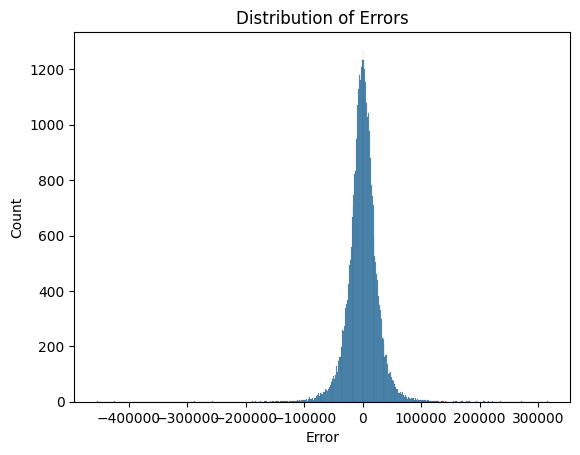

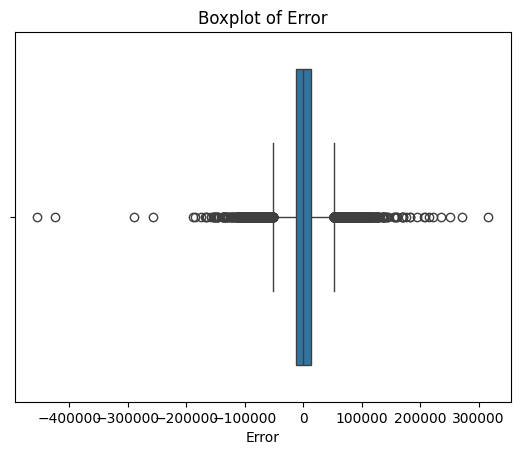

R squared on train: 0.9946438030238732
R squared on validation: 0.9698783007635554
R squared on test: 0.9685763950486885


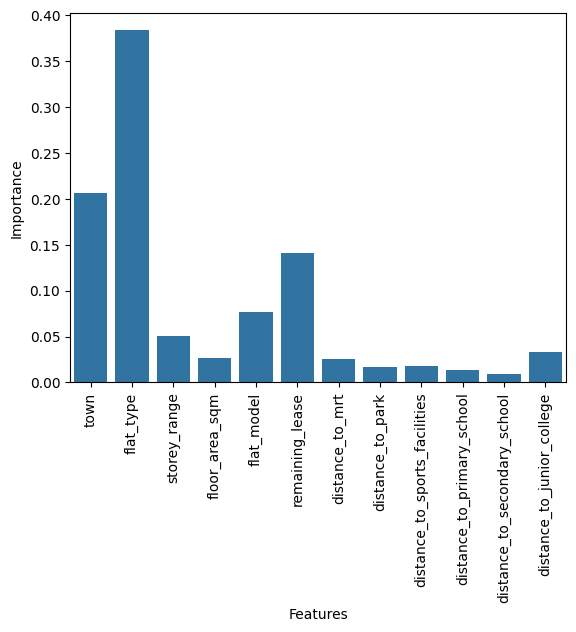

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", regressor.score(X_train, y_train))
print("R squared on validation:", regressor.score(X_val, y_val))
print("R squared on test:", regressor.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = regressor.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,18554.016707
2 ROOM,14859.138196
3 ROOM,19975.916005
4 ROOM,23928.566566
5 ROOM,29484.657212
EXECUTIVE,38086.862844
MULTI-GENERATION,38644.764320


,adjusted_price
flat_type,
1 ROOM,11351.828588
2 ROOM,10425.846398
3 ROOM,13966.828833
4 ROOM,16996.763663
5 ROOM,20612.566349
EXECUTIVE,25485.485416
MULTI-GENERATION,26395.148719


### Grid Search XGBoost

<b> Chosen for faster fitting, best rmse

In [ ]:
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(400, 1500, 50),
    'max_depth': np.arange(12, 35),
    'learning_rate': np.linspace(0.001, 0.5, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 5, 10)
}

# Initialize the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV with n_iter set to a large number
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=1,              # Number of parameter samples to try
    scoring='neg_mean_squared_error',
    cv=5,
    random_state=42,
    verbose=0
)

# Calculate the time taken for one iteration
start_time = time.time()
random_search.fit(X_train, y_train)
end_time = time.time()
time_per_iteration = (end_time - start_time) / random_search.n_iter
print(f"Estimated time per iteration: {time_per_iteration:.2f} seconds")

Estimated time per iteration: 495.27 seconds


In [ ]:
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

X_train = np.vstack((X_train, X_val))
y_train = np.hstack((y_train, y_val))

# Define the parameter grid
param_distributions = {
    'n_estimators': np.arange(100, 1000, 50),
    'max_depth': np.arange(3, 25),
    'learning_rate': np.linspace(0.001, 0.5, 10),
    'subsample': np.linspace(0.6, 1.0, 5),
    'colsample_bytree': np.linspace(0.6, 1.0, 5),
    'gamma': np.linspace(0, 5, 10)
}

# Initialize the model
xgb = XGBRegressor(objective='reg:squarederror', random_state=42)

# Initialize RandomizedSearchCV with n_iter set to a large number
random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,              # Number of parameter samples to try
    scoring='neg_mean_squared_error',
    cv=KFold(4, shuffle = True, random_state = 42),
    random_state=42,
    verbose=0
)

# Estimate total time
total_time_estimate = time_per_iteration * random_search.n_iter
print(f"Estimated total time for {random_search.n_iter} iterations: {total_time_estimate/60:.2f} minutes")

# Use tqdm for a progress bar
random_search.fit(X_train, y_train)

Estimated total time for 40 iterations: 330.18 minutes


RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                        'learning_rate': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 22, 23, 24]),
                                        'n_estimators': array([100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700,
       750, 800, 850, 900, 950]),
                                        'subsample': array([0.6, 0.7, 0.8, 0.9, 1. ])},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
pickle.dump(random_search, open('xgboost_0001_model', 'wb'))

In [ ]:
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

import pickle
with open('xgboost_0001_model.txt', 'rb') as fp:
  xgb = pickle.load(fp)

print(xgb)

def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return mse, rmse

y_pred = xgb.predict(X_train)
print(f"R2 on train: {r2_score(y_train, y_pred)}")
y_pred = xgb.predict(X_test)
print(f"R2 on test: {r2_score(y_test, y_pred)}")
mse, rmse = evaluate_model(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

RandomizedSearchCV(cv=KFold(n_splits=4, random_state=42, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=Non...
                                        'learning_rate': array([0.001     , 0.05644444, 0.11188889, 0.16733333, 0.22277778,
       0.27822222, 0.33366667, 0.38911111, 0.44455556, 0.5       ]),
                                        

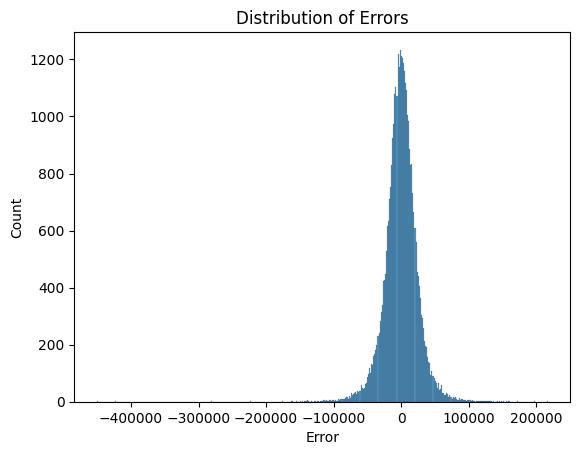

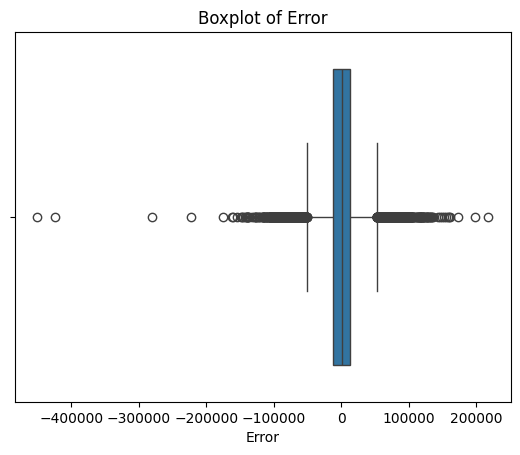

R squared on train: 0.9846805157251506
R squared on validation: 0.9850273615850647
R squared on test: 0.9723861247177363


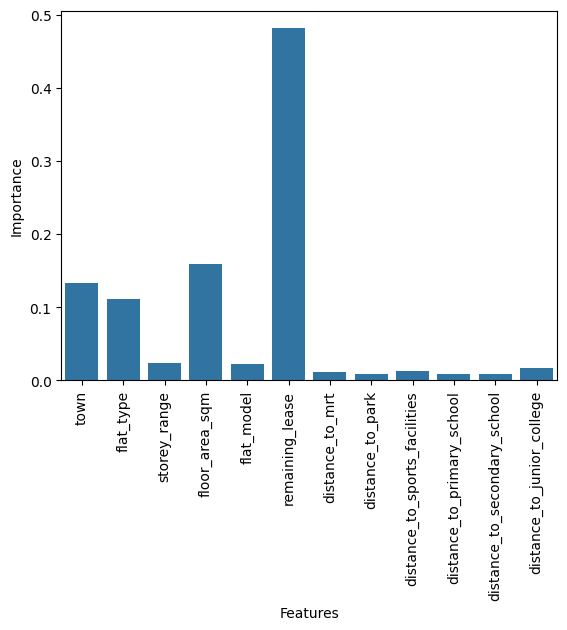

In [ ]:
sns.histplot(y_pred - y_test)
plt.title("Distribution of Errors")
plt.ylabel("Count")
plt.xlabel("Error")
plt.show()
sns.boxplot(y_pred - y_test, orient = 'h')
plt.xlabel("Error")
plt.title("Boxplot of Error")
plt.show()
print("R squared on train:", xgb.best_estimator_.score(X_train, y_train))
print("R squared on validation:", xgb.best_estimator_.score(X_val, y_val))
print("R squared on test:", xgb.best_estimator_.score(X_test, y_test))
sns.barplot(x = X_train_columns, y = xgb.best_estimator_.feature_importances_)
plt.xticks(rotation = 90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [ ]:
# error split by flat type
std_func = partial(np.std, axis = 0)
mean_error_flat_type = pd.concat(((y_pred - y_test)**2, df_test['flat_type']), axis = 1).groupby('flat_type').apply(np.mean).apply(np.sqrt)
std_error_flat_type = pd.concat((((y_pred - y_test)**2).apply(np.sqrt), df_test['flat_type']), axis = 1).groupby('flat_type').apply(std_func)
display(HTML("<b>RMSE</b>"))
display(mean_error_flat_type)
display(HTML("<b>Standard Deviation RSE</b>"))
display(std_error_flat_type)

,0
flat_type,
1 ROOM,16453.547319
2 ROOM,14833.777009
3 ROOM,18813.085956
4 ROOM,22880.398242
5 ROOM,27713.032192
EXECUTIVE,35456.542622
MULTI-GENERATION,44073.131720


,adjusted_price
flat_type,
1 ROOM,10737.014277
2 ROOM,10588.659502
3 ROOM,12720.263423
4 ROOM,15760.787712
5 ROOM,18727.361658
EXECUTIVE,23804.205494
MULTI-GENERATION,25315.141332


# Error Analysis

In [76]:
X_train = df.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
X_train_columns = X_train.columns
y_train = df['adjusted_price']
X_val = df_val.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_val = df_val['adjusted_price']
X_test = df_test.drop(columns=['adjusted_price']).drop(columns = columns_to_drop)
y_test = df_test['adjusted_price']

ct = make_column_transformer(X_train, town_transform = '', flat_model_transform = 'kmeans')
X_train = ct.fit_transform(X_train)
X_val = ct.transform(X_val)
X_test = ct.transform(X_test)

with open('xgboost_0001_model.txt', 'rb') as fp:
  model = pickle.load(fp)

# Predict on test data
y_pred = model.predict(X_test)

# Calculate errors
errors = np.abs(y_test - y_pred)

# Identify data points with highest error
top_k = 10  # Number of points with highest error
error_df = pd.DataFrame({
    "actual": y_test,
    "predicted": y_pred,
    "error": errors,
})

ref_test_set = error_df.sort_values(by="error", ascending=False).head(top_k)
error_df = error_df.reset_index(drop = True).sort_values(by="error", ascending=False).head(top_k)

# display()
# display(error_df.head())

# Add corresponding features to the DataFrame
high_error_data = pd.DataFrame(X_test[error_df.index])
# display(high_error_data)
error_df = pd.concat([error_df.reset_index(drop=True), high_error_data.reset_index(drop=True)], axis=1)

print("Top data points with highest errors:")
display(error_df)

# Similarity Analysis
scaler = StandardScaler()
scaled_data = scaler.fit_transform(high_error_data)

# Compute cosine similarity
similarity_matrix = cosine_similarity(scaled_data)

# Create a similarity DataFrame
similarity_df = pd.DataFrame(similarity_matrix, index=high_error_data.index, columns=high_error_data.index)

print("\nSimilarity matrix between high-error data points:")
display(similarity_df)

# Analyze similarity
most_similar_points = similarity_df.unstack().sort_values(ascending=False)
most_similar_points = most_similar_points[most_similar_points.index.get_level_values(0) != most_similar_points.index.get_level_values(1)]
print("\nMost similar data points among high-error points:")
print(most_similar_points.head(5))


Top data points with highest errors:


,actual,predicted,error,0,1,2,3,4,5,6,7,8,9,10,11
0,1.088000e+06,6.375273e+05,450472.687500,22.0,4.875197,6.0,3.0,51.0,0.0,0.370526,0.186946,0.544056,0.569567,0.706458,2.548189
1,1.139898e+06,7.161544e+05,423743.468360,22.0,5.170484,6.0,3.0,48.0,0.0,0.421096,0.101431,0.484551,0.509215,0.782454,2.634778
2,1.031864e+06,7.517134e+05,280150.319818,24.0,4.948760,9.0,5.0,67.0,0.0,1.044155,0.250996,0.534396,0.679747,0.679747,0.486740
3,9.679972e+05,7.456308e+05,222366.374560,24.0,4.969813,3.0,5.0,64.0,0.0,0.657985,0.826520,0.400399,0.548914,0.235877,0.946464
4,9.211079e+05,1.138628e+06,217520.232169,24.0,4.787492,33.0,4.0,89.0,0.0,0.772720,0.315060,0.845832,0.216129,0.152237,0.713279
5,7.417343e+05,9.389246e+05,197190.374457,25.0,4.955827,6.0,5.0,67.0,0.0,0.299334,0.414177,1.734373,0.155097,1.064243,3.328324
6,5.986118e+05,4.232144e+05,175397.358456,19.0,4.304065,9.0,2.0,60.0,1.0,0.063407,0.610702,0.420078,0.408584,0.456327,1.418576
7,6.715987e+05,8.439816e+05,172382.816418,25.0,4.804021,15.0,4.0,65.0,1.0,0.357506,0.446334,1.396686,0.451938,1.408873,3.637916
8,7.000000e+05,5.378956e+05,162104.375000,7.0,4.997212,12.0,5.0,64.0,0.0,1.155137,1.618243,0.319237,0.902450,0.434384,1.858121
9,6.996322e+05,5.388191e+05,160813.145658,7.0,4.997212,6.0,5.0,63.0,0.0,0.784853,1.327750,0.169110,0.511295,0.159717,1.791079



Similarity matrix between high-error data points:


,0,1,2,3,4,5,6,7,8,9
0,1.000000,0.860877,-0.229181,-0.213599,-0.532529,0.034792,0.242603,0.077303,-0.383118,-0.358384
1,0.860877,1.000000,-0.134929,-0.135554,-0.508441,0.110969,-0.102802,0.049453,-0.305658,-0.238712
2,-0.229181,-0.134929,1.000000,0.549446,0.166979,-0.309650,-0.480063,-0.403376,0.253868,0.013655
3,-0.213599,-0.135554,0.549446,1.000000,-0.056511,-0.296114,-0.309920,-0.711058,0.287105,0.452065
4,-0.532529,-0.508441,0.166979,-0.056511,1.000000,-0.027659,-0.028862,-0.137994,-0.188427,-0.173509
5,0.034792,0.110969,-0.309650,-0.296114,-0.027659,1.000000,-0.247304,0.569290,-0.546127,-0.433360
6,0.242603,-0.102802,-0.480063,-0.309920,-0.028862,-0.247304,1.000000,0.217117,-0.382474,-0.256522
7,0.077303,0.049453,-0.403376,-0.711058,-0.137994,0.569290,0.217117,1.000000,-0.449215,-0.660139
8,-0.383118,-0.305658,0.253868,0.287105,-0.188427,-0.546127,-0.382474,-0.449215,1.000000,0.789010
9,-0.358384,-0.238712,0.013655,0.452065,-0.173509,-0.433360,-0.256522,-0.660139,0.789010,1.000000



Most similar data points among high-error points:
1  0    0.860877
0  1    0.860877
9  8    0.789010
8  9    0.789010
7  5    0.569290
dtype: float64


In [74]:
df_test.loc[ref_test_set.index][0:2]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,adjusted_price,distance_to_mrt,distance_to_park,distance_to_sports_facilities,distance_to_primary_school,distance_to_secondary_school,distance_to_junior_college
75849,2020-08,BUKIT MERAH,4 ROOM,43,MOH GUAN TER,04 TO 06,131.0,Adjoined flat,1973,51 years 05 months,1088000.0,1.088000e+06,0.370526,0.186946,0.544056,0.569567,0.706458,2.548189
154815,2023-06,BUKIT MERAH,4 ROOM,50,MOH GUAN TER,04 TO 06,176.0,Adjoined flat,1973,48 years 08 months,1500000.0,1.139898e+06,0.421096,0.101431,0.484551,0.509215,0.782454,2.634778


<b> Of top errors, two of them were million dollar sales. This is generally a rarer occurance which may lead to the model being less able to narrow down the price

In [75]:
df_test.loc[ref_test_set.index]

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,adjusted_price,distance_to_mrt,distance_to_park,distance_to_sports_facilities,distance_to_primary_school,distance_to_secondary_school,distance_to_junior_college
75849,2020-08,BUKIT MERAH,4 ROOM,43,MOH GUAN TER,04 TO 06,131.0,Adjoined flat,1973,51 years 05 months,1088000.0,1.088000e+06,0.370526,0.186946,0.544056,0.569567,0.706458,2.548189
154815,2023-06,BUKIT MERAH,4 ROOM,50,MOH GUAN TER,04 TO 06,176.0,Adjoined flat,1973,48 years 08 months,1500000.0,1.139898e+06,0.421096,0.101431,0.484551,0.509215,0.782454,2.634778
178579,2024-05,BISHAN,EXECUTIVE,241,BISHAN ST 22,07 TO 09,141.0,Apartment,1992,67 years 03 months,1448000.0,1.031864e+06,1.044155,0.250996,0.534396,0.679747,0.679747,0.486740
87886,2021-01,BISHAN,EXECUTIVE,134,BISHAN ST 12,01 TO 03,144.0,Apartment,1986,64 years 11 months,1028000.0,9.679972e+05,0.657985,0.826520,0.400399,0.548914,0.235877,0.946464
83069,2020-11,BISHAN,5 ROOM,273B,BISHAN ST 24,31 TO 33,120.0,DBSS,2011,89 years 10 months,950000.0,9.211079e+05,0.772720,0.315060,0.845832,0.216129,0.152237,0.713279
85685,2020-12,BUKIT TIMAH,EXECUTIVE,7,TOH YI DR,04 TO 06,142.0,Apartment,1989,67 years 10 months,765000.0,7.417343e+05,0.299334,0.414177,1.734373,0.155097,1.064243,3.328324
159590,2023-08,KALLANG/WHAMPOA,3 ROOM,105,TOWNER RD,07 TO 09,74.0,Model A,1984,60 years 04 months,798000.0,5.986118e+05,0.063407,0.610702,0.420078,0.408584,0.456327,1.418576
122337,2022-01,BUKIT TIMAH,5 ROOM,17,TOH YI DR,13 TO 15,122.0,Improved,1988,65 years 07 months,800000.0,6.715987e+05,0.357506,0.446334,1.396686,0.451938,1.408873,3.637916
74145,2020-07,JURONG WEST,EXECUTIVE,409,JURONG WEST ST 42,10 TO 12,148.0,Maisonette,1985,64 years 02 months,700000.0,7.000000e+05,1.155137,1.618243,0.319237,0.902450,0.434384,1.858121
93350,2021-03,JURONG WEST,EXECUTIVE,440,JURONG WEST AVE 1,04 TO 06,148.0,Adjoined flat,1985,63 years 02 months,743000.0,6.996322e+05,0.784853,1.327750,0.169110,0.511295,0.159717,1.791079


<b> Central Area flats experience more error. In general, higher valuation will lead to higher error

# <hr>

Concluding remarks on errors:<br><br>
<b> In general flat_types with lower prices in general have lesser errror while those that are more expensive face higher errors.
<br><br>
<b>flat_types with more data /rows (i.e. 4 Room, 3 Room, 5 Room)  are better able to narrow down the error range (i.e. lower standard deviation). Though there is stil a possibility that the magnitude of standard deviation is nature of adjusted price by flat_types